In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr
import utils_results as ut

In [2]:
basin = 'NEP'
fitness_model = 'all' # all, linreg, lgbm, pi-lgbm
cluster_type = '_nc' # all, _nc, Anc, DSnc
final_model = 'all' # all, mlp, lgbm, pi-mlp, pi-lgbm
n_clusters = 5 # from 5 to 12, 4 means no number of clusters considered

In [3]:
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')
track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
track_df = pd.read_csv(track_file, index_col=0)
performance_col = ['R_Y_mlp', 'R_Y_pi-mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm']
track_df['max_R_Y'] = track_df[performance_col].max(axis=1)
sorted_df = track_df.sort_values('max_R_Y', ascending=False)
best_model = sorted_df.index[0]
print(f'Best trained model is in simulation: {best_model}')
sel_row = track_df.loc[best_model]
best_model_kind = sel_row[performance_col].idxmax()
print(f'Best trained model is: {best_model_kind.split("_")[-1]}')
print(f'Best trained model performance: {sel_row[best_model_kind]:.4f}')

Best trained model is in simulation: test2_pi-lgbm_nc5_nv8_nd9
Best trained model is: mlp
Best trained model performance: 0.6517


In [4]:
# Get the number of features selected for each simulation and the selected variables
atm_vars = ['abs_vo850', 'mpi', 'msl', 'r700', 'sst', 'vo850', 'vws850-200', 'w']
idx_vars = ['EA-WR', 'ENSO3.4', 'EP-NP', 'NAO', 'PDO', 'PNA', 'SOI', 'TNA', 'TSA', 'WP', 'month']
experiments_folders = []
selected_vars_df_list = []
for exp, experiment in enumerate(track_df.iterrows()):
    experiment_folder = experiment[0]
    output_dir = os.path.join(results_dir, basin, experiment_folder)
    n_clus = experiment[1]['n_clusters']
    model_kind = experiment[1]['model']
    n_vars = ''.join(filter(str.isdigit, experiment[0].split('_')[-2]))
    n_idxs = ''.join(filter(str.isdigit, experiment[0].split('_')[-1]))
    experiment_filename = f'1970-2022_{n_clus}clusters_{n_vars}vars_{n_idxs}idxs.csv'
    sol_filename = f'{model_kind}_' + experiment_filename
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    predictor_file = 'predictors_' + experiment_filename
    nc_string = experiment[0].split('_')[2]
    if "A" in nc_string:
        cluster_data = f'{basin}_{n_clus}clusters_anomaly'
    elif "DS" in nc_string:
        cluster_data = f'{basin}_{n_clus}clusters_deseason'
    else:
        cluster_data = f'{basin}_{n_clus}clusters'
    data_dir = os.path.join(fs_dir, 'data', cluster_data)
    predictors_path = os.path.join(data_dir, predictor_file)
    predictors_df = pd.read_csv(predictors_path, index_col=0)
    predictors_df.index = pd.to_datetime(predictors_df.index)
    # Append the experiment folder name to the list and the list of selected variables
    selected_vars_df = ut.df_selected_vars(predictors_df, best_solution)
    selected_vars_df_list.append(selected_vars_df)
    experiments_folders.append(experiment_folder)

In [5]:
# Filter data to consider only the runs with 9 climate indices
track_df = track_df[track_df.index.str.contains('nd9')]
# Filter the data according to the selected fitness model
if fitness_model != 'all':
    track_df = track_df[track_df.index.str.contains(fitness_model)]
# Filter the data according to the selected clustering type
if cluster_type != 'all':
    track_df = track_df[track_df.index.str.contains(cluster_type)]
# If selected a specific number of clusters filter the df according to that number of clusters
if n_clusters != 4 and cluster_type != 'all':
    track_df = track_df[track_df['n_clusters'] == n_clusters]
# Get the top runs according to the selected final model
if final_model != 'all':
    performance_col = f'R_Y_{final_model}'
    sorted_df = track_df.sort_values(performance_col, ascending=False)
    performance_col_noFS = f'R_Y_{final_model}_noFS'
    sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
else:
    performance_col = ['R_Y_mlp', 'R_Y_pi-mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm']
    track_df['max_R_Y'] = track_df[performance_col].max(axis=1)
    sorted_df = track_df.sort_values('max_R_Y', ascending=False)
    performance_col_noFS = ['R_Y_mlp_noFS', 'R_Y_pi-mlp_noFS', 'R_Y_lgbm_noFS', 'R_Y_pi-lgbm_noFS']
    track_df['max_R_Y_noFS'] = track_df[performance_col_noFS].max(axis=1)
    sorted_df_noFS = track_df.sort_values('max_R_Y_noFS', ascending=False)

In [6]:
perc = 80

Top 5 runs variables selection percentages


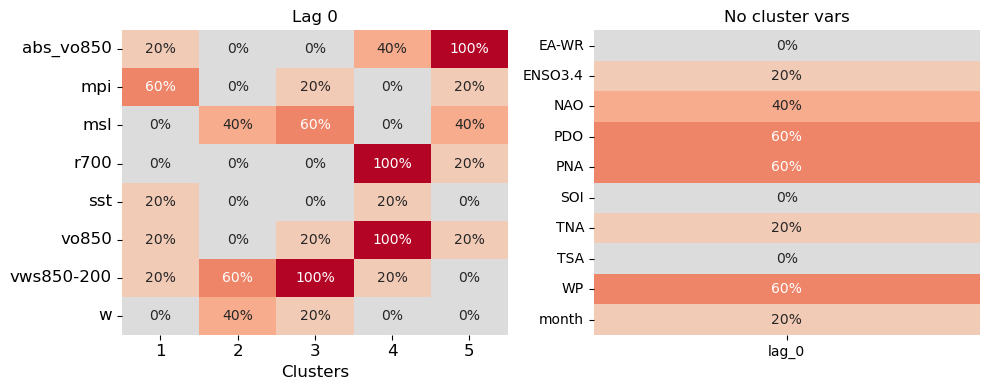

In [7]:
# Plot the variables selection for the best 5 runs if a certain number of clusters and a specific clustering type is selected
if cluster_type != 'all' and n_clusters != 4:
    print(f'Top 5 runs variables selection percentages')
    runs = sorted_df.iloc[:5].index.to_numpy()
    idxss = np.where(np.isin(experiments_folders, runs))[0]
    sel_vars = [selected_vars_df_list[i] for i in idxss]
    heatmap, dfx_1 = ut.vars_selection_heatmaps(runs, n_clusters, sel_vars, atm_vars, idx_vars, display_percentage=True, sel_percentage=perc)

Runs 5-10 variables selection percentages
Variables selected at least 80% of the time both in the top 5 and 5-10 runs: ['r700_cluster4', 'vo850_cluster4', 'vws850-200_cluster3']
Variables selected at least 80% of the time only in the 5-10 runs: ['msl_cluster2', 'msl_cluster4', 'vws850-200_cluster2', 'WP', 'month']


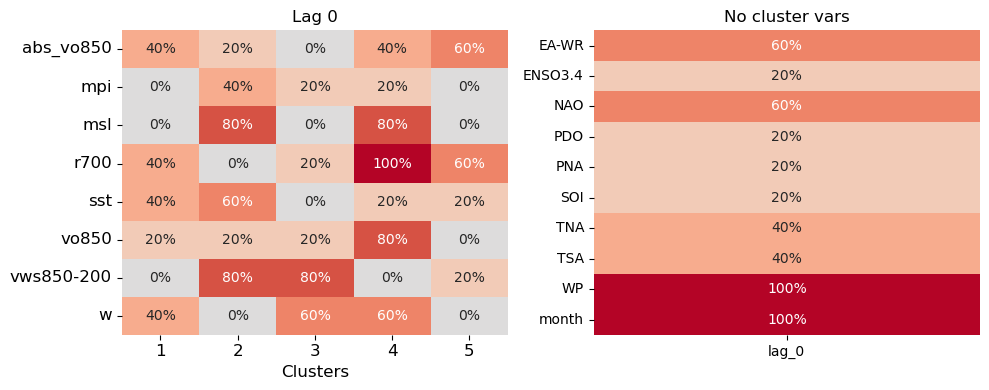

In [8]:
# Plot the variables selection for the 5-10 runs if a certain number of clusters and a specific clustering type is selected
if cluster_type != 'all' and n_clusters != 4 and len(sorted_df) > 5:
    print(f'Runs 5-10 variables selection percentages')
    runs = sorted_df.iloc[5:10].index.to_numpy()
    idxss = np.where(np.isin(experiments_folders, runs))[0]
    sel_vars = [selected_vars_df_list[i] for i in idxss]
    heatmap, dfx_2 = ut.vars_selection_heatmaps(runs, n_clusters, sel_vars, atm_vars, idx_vars, display_percentage=True, sel_percentage=perc)
    # Variables in common and not between the top 5 runs and the 5-10 runs
    idxs_vars = np.where(np.isin(dfx_2.selected_vars[0], dfx_1.selected_vars[0]))[0]
    var_in_both2 = [dfx_2.selected_vars[0][i] for i in idxs_vars]
    var_only_in_2 = [dfx_2.selected_vars[0][i] for i in range(len(dfx_2.selected_vars[0])) if i not in idxs_vars]
    print(f'Variables selected at least {perc}% of the time both in the top 5 and 5-10 runs: {var_in_both2}')
    print(f'Variables selected at least {perc}% of the time only in the 5-10 runs: {var_only_in_2}')

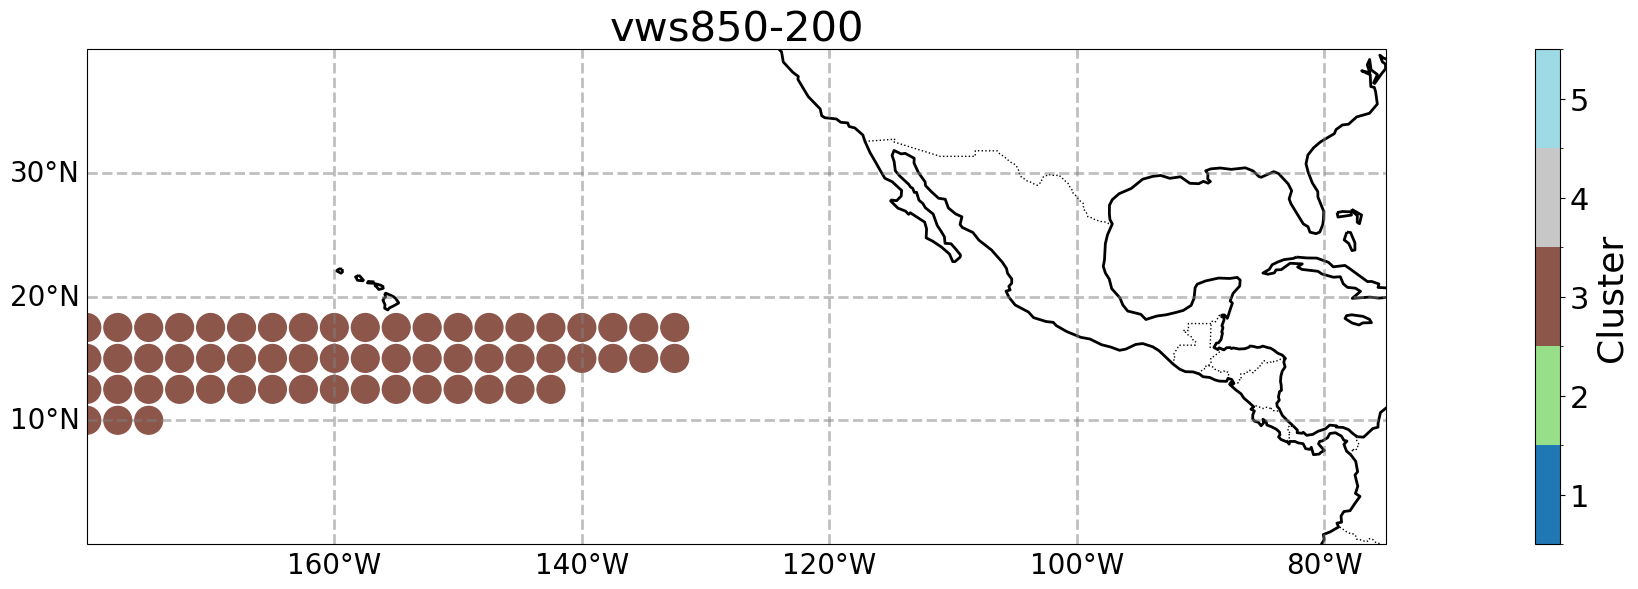

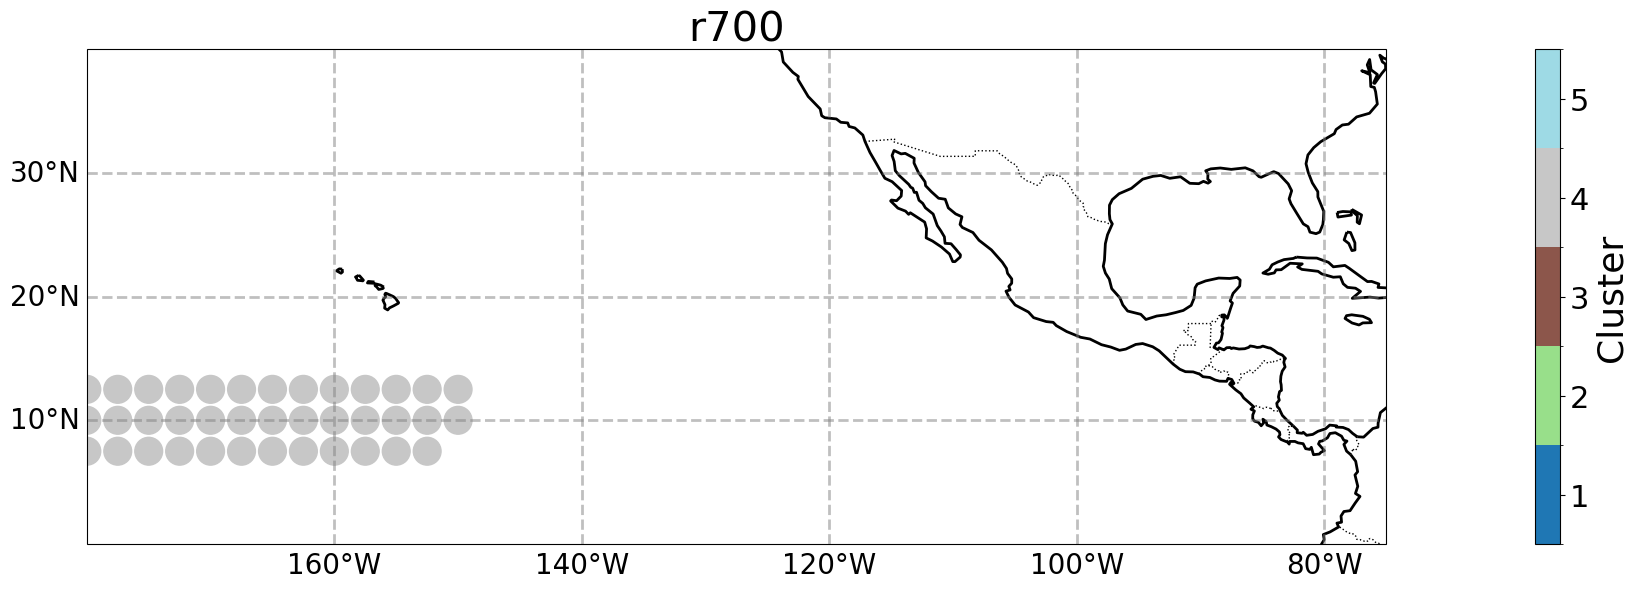

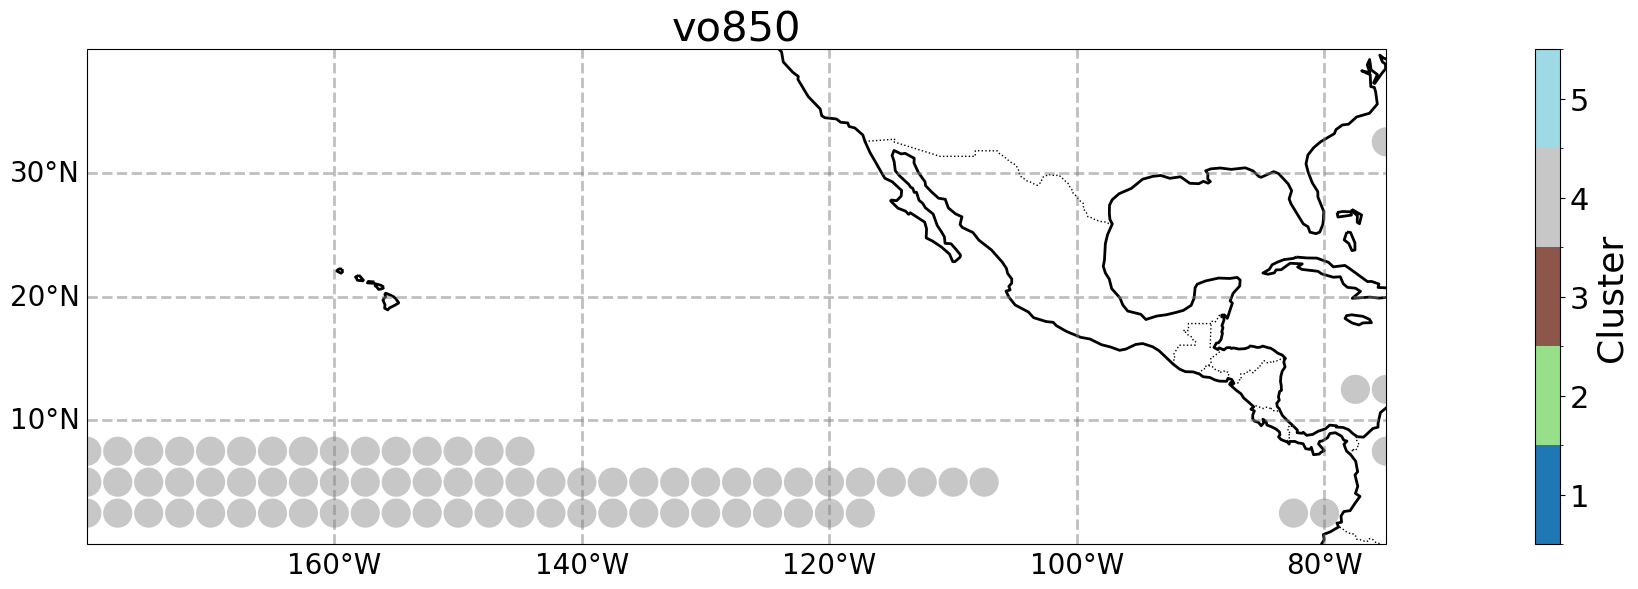

In [10]:
# Plot clusters of variables over selected x% of the times in the top 5 and 5-10 runs
# Get the variable names from the selected variables
label_selected_vars = var_in_both2
variables_with_cluster = [var for var in label_selected_vars if 'cluster' in var]
variable_names = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names = list(set(variable_names))

for v, var in enumerate(variable_names):
    fig = ut.plot_clusters_variable(var, basin, n_clusters, label_selected_vars, data_dir)

Runs 10-15 variables selection percentages
Variables selected at least 80% of the time both in the top 5 and 10-15 runs: ['abs_vo850_cluster5', 'vo850_cluster4', 'vws850-200_cluster3']
Variables selected at least 80% of the time only in the 10-15 runs: ['WP']


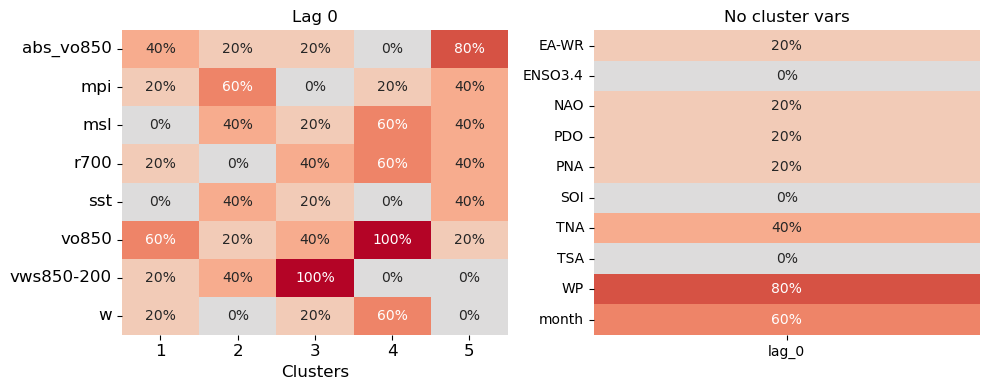

In [12]:
# Plot the variables selection for the 10-15 runs if a certain number of clusters and a specific clustering type is selected
if cluster_type != 'all' and n_clusters != 4 and len(sorted_df) > 10:
    print(f'Runs 10-15 variables selection percentages')
    runs = sorted_df.iloc[10:].index.to_numpy()
    idxss = np.where(np.isin(experiments_folders, runs))[0]
    sel_vars = [selected_vars_df_list[i] for i in idxss]
    heatmap, dfx_3 = ut.vars_selection_heatmaps(runs, n_clusters, sel_vars, atm_vars, idx_vars, display_percentage=True, sel_percentage=perc)
    # Variables in common and not between the top 5 runs and the 10-15 runs
    idxs_vars = np.where(np.isin(dfx_3.selected_vars[0], dfx_1.selected_vars[0]))[0]
    var_in_both3 = [dfx_3.selected_vars[0][i] for i in idxs_vars]
    var_only_in_3 = [dfx_3.selected_vars[0][i] for i in range(len(dfx_3.selected_vars[0])) if i not in idxs_vars]
    print(f'Variables selected at least {perc}% of the time both in the top 5 and 10-15 runs: {var_in_both3}')
    print(f'Variables selected at least {perc}% of the time only in the 10-15 runs: {var_only_in_3}')

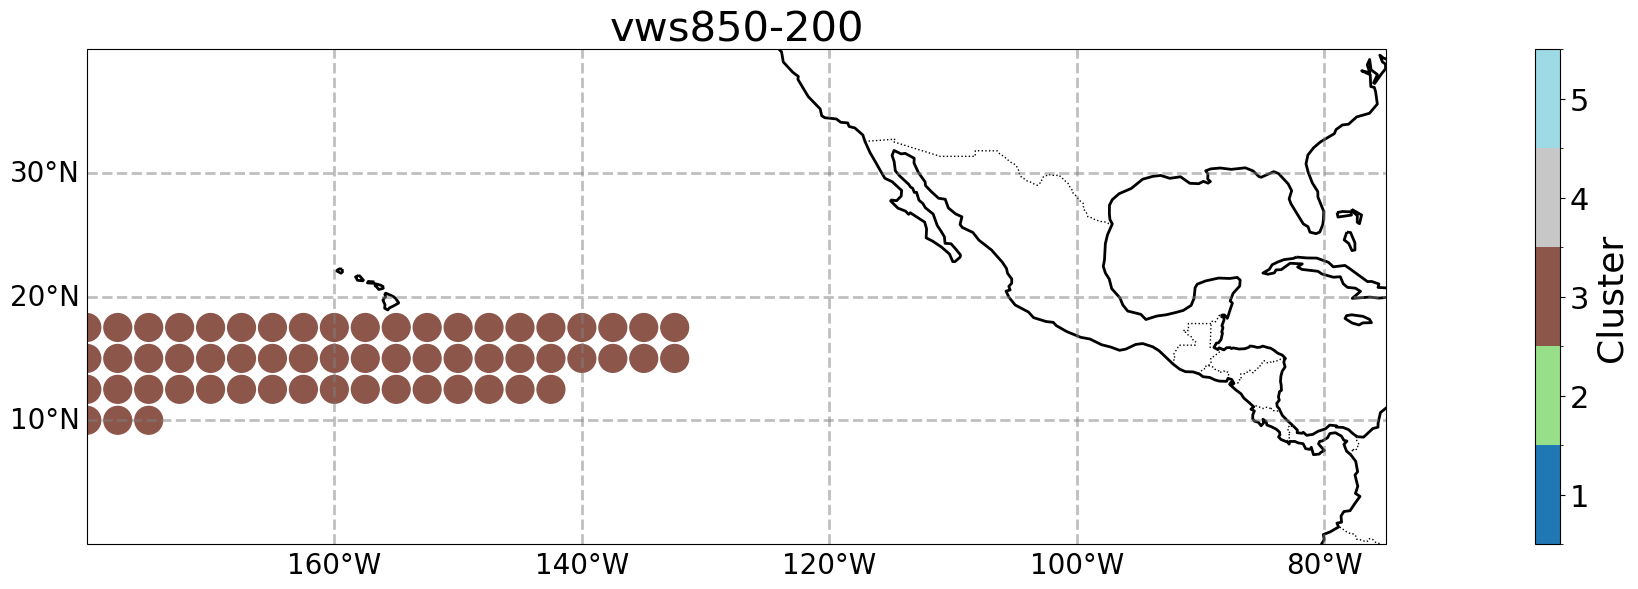

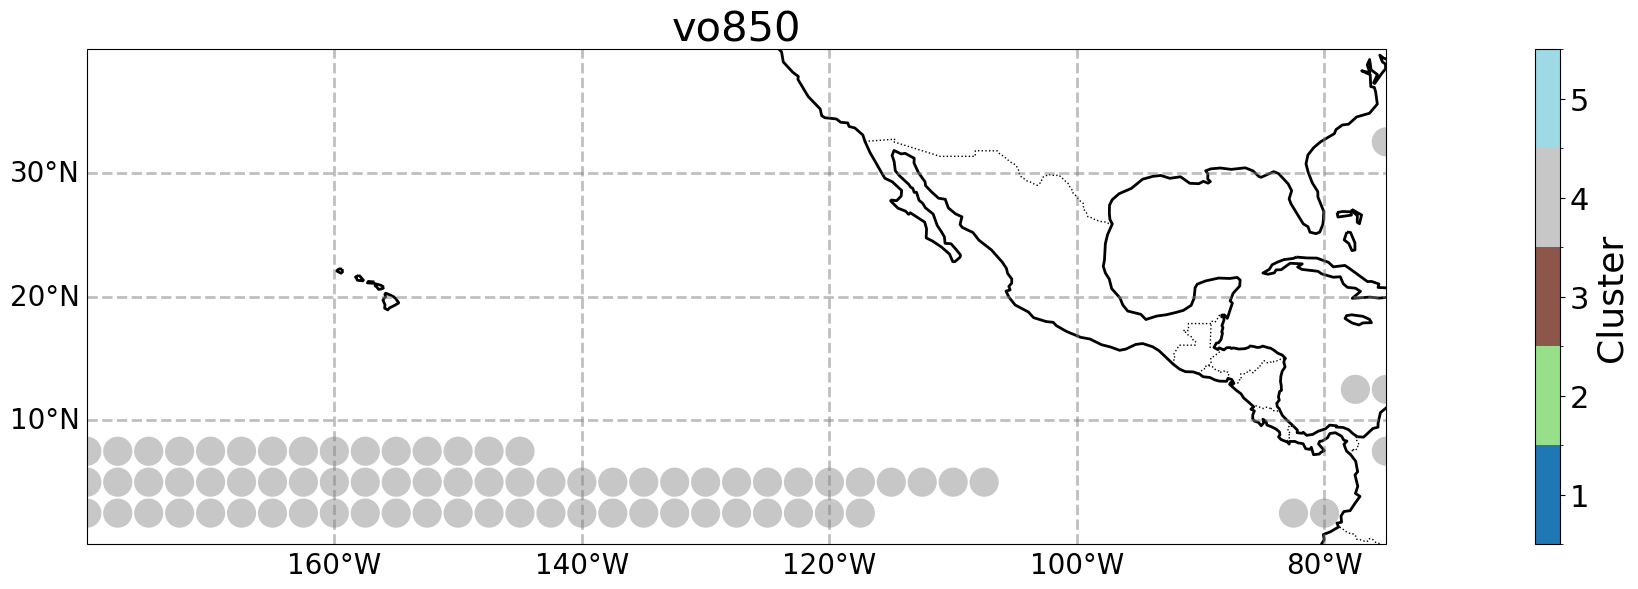

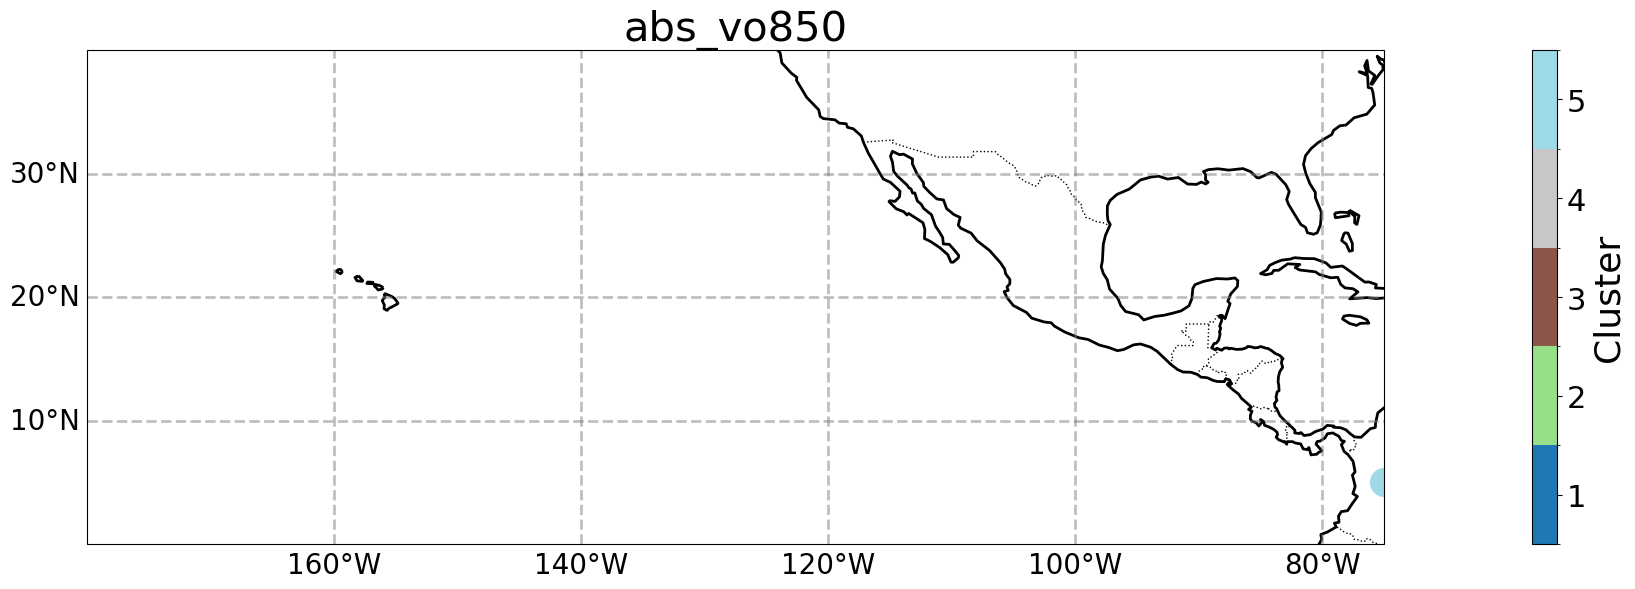

In [13]:
# Plot clusters of variables over selected x% of the times in the top 5 and 5-10 runs
# Get the variable names from the selected variables
label_selected_vars = var_in_both3
variables_with_cluster = [var for var in label_selected_vars if 'cluster' in var]
variable_names = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names = list(set(variable_names))

for v, var in enumerate(variable_names):
    fig = ut.plot_clusters_variable(var, basin, n_clusters, label_selected_vars, data_dir)

In [19]:
track_df[['R_Y_mlp', 'R_Y_pi-mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm']].to_numpy().reshape(-1)

array([ 0.00378944,  0.10516118,  0.02729034,  0.25021994,  0.34417111,
       -0.08079981, -0.04390717,  0.43348462,  0.37791985, -0.2274916 ,
       -0.14733937,  0.41449847,  0.45724621,  0.13364095, -0.27036441,
        0.42705792,  0.21798051,  0.14763717, -0.36822912,  0.45154049])

In [22]:
BestRYs = []
RYs = np.array([])
BestRYs_noFS = []
RYs_noFS = np.array([])
BestRYs_nc = []
RYs_nc = np.array([])
BestRYs_nc_noFS = []
RYs_nc_noFS = np.array([])
BestRYs_Anc = []
RYs_Anc = np.array([])
BestRYs_Anc_noFS = []
RYs_Anc_noFS = np.array([])
BestRYs_DSnc = []
RYs_DSnc = np.array([])
BestRYs_DSnc_noFS = []
RYs_DSnc_noFS = np.array([])

for basin in ['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']:
    for cluster_type in ['_nc', 'Anc', 'DSnc']:
        for fitness_model in ['linreg', 'lgbm', 'pi-lgbm']:
            for n_clusters_widg in range(5, 13):
                track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
                track_df = pd.read_csv(track_file, index_col=0)
                track_df = track_df[track_df.index.str.contains('nd9')]
                track_df = track_df[track_df.index.str.contains(fitness_model)]
                track_df = track_df[track_df.index.str.contains(cluster_type)]
                track_df = track_df[track_df['n_clusters'] == n_clusters_widg]
                # Get the top runs according to the selected final model
                if final_model != 'all':
                    performance_col = f'R_Y_{final_model}'
                    sorted_df = track_df.sort_values(performance_col, ascending=False)
                    performance_col_noFS = f'R_Y_{final_model}_noFS'
                    sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
                else:
                    performance_col = ['R_Y_mlp', 'R_Y_pi-mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm']
                    track_df['max_R_Y'] = track_df[performance_col].max(axis=1)
                    sorted_df = track_df.sort_values('max_R_Y', ascending=False)
                    performance_col_noFS = ['R_Y_mlp_noFS', 'R_Y_pi-mlp_noFS', 'R_Y_lgbm_noFS', 'R_Y_pi-lgbm_noFS']
                    track_df['max_R_Y_noFS'] = track_df[performance_col_noFS].max(axis=1)
                    sorted_df_noFS = track_df.sort_values('max_R_Y_noFS', ascending=False)
                
                try:
                    BestR = sorted_df['max_R_Y'].iloc[0]
                    BestR_noFS = sorted_df_noFS['max_R_Y_noFS'].iloc[0]
                    BestRYs.append(BestR)
                    BestRYs_noFS.append(BestR_noFS)
                    RYs_array = track_df[performance_col].to_numpy().reshape(-1)
                    RYs = np.concatenate((RYs, RYs_array))
                    RYs_noFS_array = track_df[performance_col_noFS].to_numpy().reshape(-1)
                    RYs_noFS = np.concatenate((RYs_noFS, RYs_noFS_array))
                except:
                    print(f'No data for {basin} - {cluster_type} - {fitness_model} - {n_clusters_widg}')
                    continue
                
                # if cluster_type == '_nc':
                #     BestRYs_nc.append(BestR)
                #     BestRYs_nc_noFS.append(BestR_noFS)
                #     RYs_nc = np.concatenate((RYs_nc, RYs_array))
                #     RYs_nc_noFS = np.concatenate((RYs_nc_noFS, RYs_noFS_array))
                # elif cluster_type == 'Anc':
                #     BestRYs_Anc.append(BestR)
                #     BestRYs_Anc_noFS.append(BestR_noFS)
                #     RYs_Anc = np.concatenate((RYs_Anc, RYs_array))
                #     RYs_Anc_noFS = np.concatenate((RYs_Anc_noFS, RYs_noFS_array))
                # elif cluster_type == 'DSnc':
                #     BestRYs_DSnc.append(BestR)
                #     BestRYs_DSnc_noFS.append(BestR_noFS)
                #     RYs_DSnc = np.concatenate((RYs_DSnc, RYs_array))
                #     RYs_DSnc_noFS = np.concatenate((RYs_DSnc_noFS, RYs_noFS_array))
    #             # if BestR_noFS > BestR:
    #             #     print(f'{cluster_type} - {fitness_model} - {n_clusters_widg} - {BestR:.3f} - {BestR_noFS:.3f}, noFs better')
    #             # else:
    #             #     print(f'{cluster_type} - {fitness_model} - {n_clusters_widg} - {BestR:.3f} - {BestR_noFS:.3f}')
    # plt.figure(figsize=(10, 6))
    # plt.boxplot([BestRYs, BestRYs_noFS, BestRYs_nc, BestRYs_nc_noFS, BestRYs_Anc, BestRYs_Anc_noFS, BestRYs_DSnc, BestRYs_DSnc_noFS], 
    #             labels=['FS', 'No FS', 'FS nc', 'No FS nc', 'FS Anc', 'No FS Anc', 'FS DSnc', 'No FS DSnc'],
    #             showfliers=True,
    #             vert=False);
    # plt.title(f'{basin} - Annual Correlations')
    # plt.figure(figsize=(10, 6))
    # plt.boxplot([RYs, RYs_noFS, RYs_nc, RYs_nc_noFS, RYs_Anc, RYs_Anc_noFS, RYs_DSnc, RYs_DSnc_noFS],
    #             labels=['FS', 'No FS', 'FS nc', 'No FS nc', 'FS Anc', 'No FS Anc', 'FS DSnc', 'No FS DSnc'],
    #             showfliers=True,
    #             vert=False);
    # plt.title(f'{basin} - Annual Correlations')

No data for NA - DSnc - pi-lgbm - 6
